In [2]:
# Import dependencies
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [213]:
# setattra() reassigns a class object to a new value
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    as_supervised=True, # include labels
    shuffle_files = True,
    
)


In [214]:
# Pretty print number training, validation, and testing samples
print(f"Number of training samples: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test samples: {tf.data.experimental.cardinality(test_ds)}")

Number of training samples: 18610
Number of validation samples: 2326
Number of test samples: 2326


In [215]:
# Automatically downloads as a tensorflow prefetch dataset (image and associated label)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

- shape=(None, None, 3) --> images probably have variable shape and are RGB
- Labels have no shape (vector)

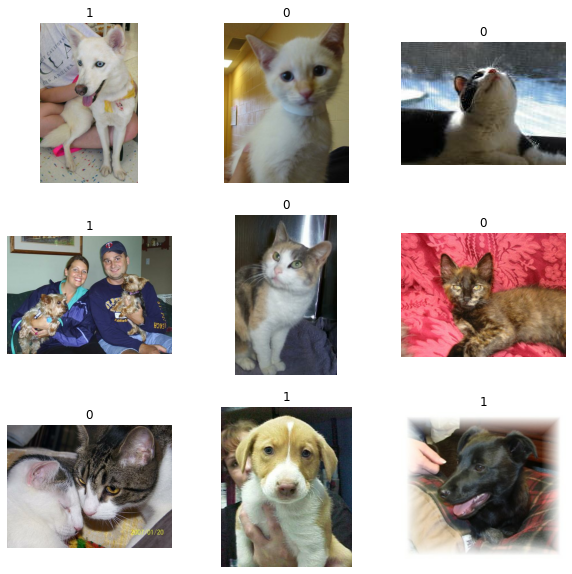

In [216]:
import matplotlib.pyplot as plt

# Let's plot 9 images and their labels
plt.figure(figsize=(10,10))

for i, (image,label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

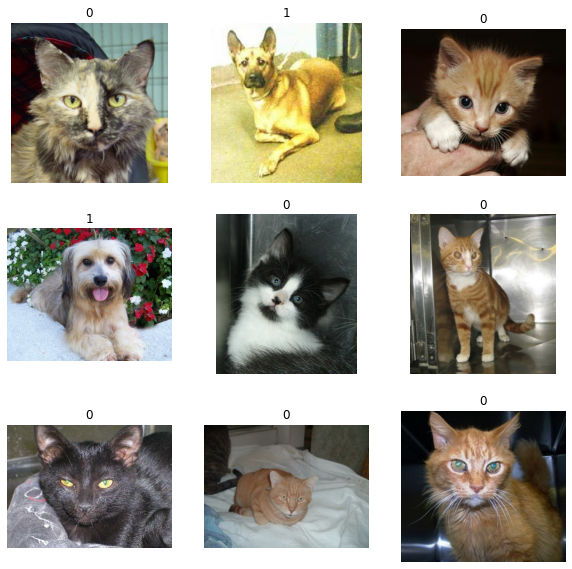

In [217]:
# Let's plot 9 images and their labels from the validation dataset
plt.figure(figsize=(10,10))

for i, (image,label) in enumerate(validation_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

As thought, the images in the dataset are of different sizes and RGB. 

## Standardizing the Data

In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data

In [7]:
# Examine the shape of the first 10 images
# Do not need label
for (image, _) in train_ds.take(10).as_numpy_iterator():
  print(image.shape)

(500, 306, 3)
(500, 388, 3)
(120, 160, 3)
(359, 500, 3)
(288, 183, 3)
(375, 500, 3)
(375, 500, 3)
(375, 305, 3)
(260, 286, 3)
(211, 222, 3)


In [8]:
# Examine pixel data of several images 
for (image, _) in train_ds.take(3).as_numpy_iterator():
  print(image)

[[[140 102  89]
  [137  99  86]
  [130  94  80]
  ...
  [233 193 168]
  [236 196 171]
  [235 195 170]]

 [[150 112  99]
  [157 119 106]
  [167 131 117]
  ...
  [231 191 166]
  [232 192 167]
  [231 191 166]]

 [[200 164 150]
  [205 169 155]
  [211 175 161]
  ...
  [229 189 164]
  [229 189 164]
  [231 191 166]]

 ...

 [[144 106 105]
  [140 102 101]
  [143 107 107]
  ...
  [101  72  74]
  [105  76  78]
  [105  76  78]]

 [[143 105 104]
  [139 101 100]
  [141 105 105]
  ...
  [103  74  76]
  [109  80  82]
  [ 99  70  72]]

 [[141 103 102]
  [137  99  98]
  [140 104 104]
  ...
  [100  71  73]
  [105  76  78]
  [ 87  58  60]]]
[[[ 58  64  62]
  [ 58  64  62]
  [ 58  64  62]
  ...
  [ 61  71  72]
  [ 57  67  68]
  [ 42  52  53]]

 [[ 58  64  62]
  [ 57  63  61]
  [ 55  61  59]
  ...
  [ 65  75  76]
  [ 62  72  73]
  [ 47  57  58]]

 [[ 65  71  69]
  [ 63  69  67]
  [ 59  65  63]
  ...
  [ 67  77  78]
  [ 66  76  77]
  [ 51  61  62]]

 ...

 [[ 77  79  74]
  [ 81  83  78]
  [ 98  99  93]
  ..

Pixel values range from 0 - 255

In [9]:
# Set constant image size
IMG_SIZE = (224,224)

# Downsize images
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x,IMG_SIZE),y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x,IMG_SIZE),y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x,IMG_SIZE),y))

In [10]:
# Ensure images were resized 
for (image, _) in train_ds.take(10).as_numpy_iterator():
  print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [11]:
# Created batched and prefetched datasets for performant data pipelines
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
# Build a function to plot the loss curves from our experiments 
def plot_loss_curves(history, figsize=(10,5)):
  """
  Function takes in the history from a trained model and plots loss and accuracy 
  for both the training and validation data. 

  Args
  ----
  history : a history object from a trained Tensorflow Model 

  Returns
  -------
  Plots the Loss and Accuracy curves for training and validation sets
  """

  # Get loss and accuracy for training and validation datasets
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  training_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Get number of epochs
  epochs = history.epoch

  # Plot the loss
  plt.figure(figsize=(figsize))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.xlabel("Epochs")
  plt.title("Loss")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, training_accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.xlabel("Epochs")
  plt.title('Accuracy')
  plt.legend()


In [13]:
from tensorflow.keras import layers

In [27]:
#os.rmdir("/content/model_experiments")

In [32]:
import os 
os.mkdir("model_experiments")

In [40]:
checkpoint_dir = "/content/model_experiments/"

In [41]:
# Create ModelCheckpoint callback to save our model's progress during training 
def model_checkpoint(model_name:str):
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + model_name,
                                                        monitor='val_accuracy',
                                                        save_best_only=True,
                                                        verbose=0)
  return model_checkpoint

In [14]:
# Specify shape of images fed into our CNN (HWC)
INPUT_SHAPE = (224,224, 3)

In [29]:
# Build model using Functional API 
# Just using Tiny VGG architecture for simplicity
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = layers.Conv2D(10, 3, activation='relu')(inputs)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_0 = tf.keras.Model(inputs, outputs, name="model_0")

In [37]:
model_0.name

'model_0'

In [43]:
model_0.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [44]:
# Summary of our model 
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                           

In [45]:
history_0 = model_0.fit(train_ds, 
                        epochs=5,
                        steps_per_epoch=len(train_ds),
                        validation_data=validation_ds,
                        validation_steps=len(validation_ds),
                        callbacks=[model_checkpoint(model_name=model_0.name)])

Epoch 1/5
582/582 [==============================] - ETA: 0s - loss: 3.2194 - accuracy: 0.5945

582/582 [==============================] - 45s 59ms/step - loss: 3.2194 - accuracy: 0.5945 - val_loss: 0.6168 - val_accuracy: 0.6711
Epoch 2/5
581/582 [============================>.] - ETA: 0s - loss: 0.5679 - accuracy: 0.6991

582/582 [==============================] - 33s 56ms/step - loss: 0.5677 - accuracy: 0.6993 - val_loss: 0.6103 - val_accuracy: 0.6978
Epoch 3/5
581/582 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7399

582/582 [==============================] - 33s 57ms/step - loss: 0.5136 - accuracy: 0.7398 - val_loss: 0.6217 - val_accuracy: 0.6999
Epoch 4/5
582/582 [==============================] - 32s 55ms/step - loss: 0.4576 - accuracy: 0.7785 - val_loss: 0.6734 - val_accuracy: 0.6969
Epoch 5/5
582/582 [==============================] - 34s 58ms/step - loss: 0.4135 - accuracy: 0.8046 - val_loss: 0.7366 - val_accuracy: 0.6978


In [46]:
model_0_results = model_0.evaluate(test_ds)
model_0_results

73/73 [==============================] - 3s 42ms/step - loss: 0.6869 - accuracy: 0.7008


[0.6868757009506226, 0.7007738351821899]

In [48]:
# Load in the best model from our checkpoint callback
model_0 = tf.keras.models.load_model("/content/model_experiments/model_0")

In [49]:
# Does it provide any improvements?
model_0_results = model_0.evaluate(test_ds)
model_0_results

73/73 [==============================] - 3s 41ms/step - loss: 0.5891 - accuracy: 0.7115


[0.589063823223114, 0.7115219235420227]

In [ ]:
# Build the CNN model (Tiny VGG Architecture) (Sequential API)
# model_0 = tf.keras.models.Sequential([
#     layers.Conv2D(10,3, activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'), # Must specify input_shape if first layer
#     layers.Conv2D(10,3,activation='relu'),
#     print(model_0.output_shape),
#     #layers.MaxPool2D(pool_size=2, padding='valid'),
#     layers.Conv2D(10,3,activation='relu'),
#     layers.Conv2D(10,3,activation='relu'),
#     #layers.MaxPool2D(2),
#     layers.Flatten(),
#     layers.Dense(1,activation='sigmoid') # Binary classification
# ])

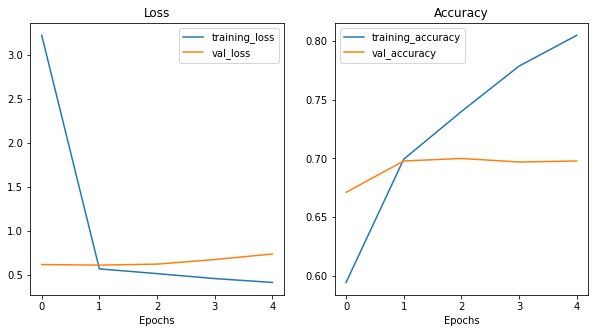

In [50]:
plot_loss_curves(history_0)

In [51]:
# Let's add a rescaling layer to our model (model_1)
# Neural Networks prefer normalization of data (pixel data between 0 & 1)
from tensorflow.keras.layers.experimental import preprocessing

# Build model using Functional API 
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = preprocessing.Rescaling(1/255.)(inputs)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name="Model_1_Rescaled")

In [52]:
model_1.name

'Model_1_Rescaled'

In [53]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [54]:
# Fitting our CNN now with normalized data 
history_1 = model_1.fit(train_ds, 
                        epochs=5,
                        steps_per_epoch=len(train_ds),
                        validation_data=validation_ds,
                        validation_steps=len(validation_ds),
                        callbacks=[model_checkpoint(model_name=model_1.name)])

Epoch 1/5
582/582 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.6574

582/582 [==============================] - 36s 61ms/step - loss: 0.6041 - accuracy: 0.6574 - val_loss: 0.5351 - val_accuracy: 0.7433
Epoch 2/5
581/582 [============================>.] - ETA: 0s - loss: 0.4823 - accuracy: 0.7665

582/582 [==============================] - 33s 57ms/step - loss: 0.4821 - accuracy: 0.7665 - val_loss: 0.5133 - val_accuracy: 0.7571
Epoch 3/5
582/582 [==============================] - 33s 57ms/step - loss: 0.4188 - accuracy: 0.8097 - val_loss: 0.5360 - val_accuracy: 0.7433
Epoch 4/5
582/582 [==============================] - 32s 56ms/step - loss: 0.3539 - accuracy: 0.8451 - val_loss: 0.6227 - val_accuracy: 0.7317
Epoch 5/5
582/582 [==============================] - 32s 55ms/step - loss: 0.2944 - accuracy: 0.8726 - val_loss: 0.7480 - val_accuracy: 0.7167


In [55]:
model_1_results = model_1.evaluate(test_ds)
model_1_results

73/73 [==============================] - 4s 53ms/step - loss: 0.6606 - accuracy: 0.7343


[0.6606359481811523, 0.7343078255653381]

In [56]:
# Load in the best model from our checkpoint callback
model_1 = tf.keras.models.load_model("/content/model_experiments/Model_1_Rescaled")

In [57]:
model_1_results = model_1.evaluate(test_ds)
model_1_results

73/73 [==============================] - 3s 42ms/step - loss: 0.4870 - accuracy: 0.7709


[0.4870499074459076, 0.7708512544631958]

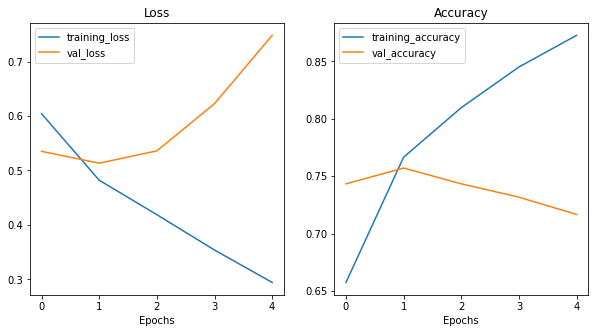

In [58]:
plot_loss_curves(history_1)

 - Normalzing our pixel data increased our accuracy by ~7 percentage points. 

- Looking at our epochs, seems like our model is overfitting to some extent. We see diverging accuracy and loss curves with our training and validation datasets

**Note:** Plots don't reflect the increase in accuracy from uploading our best model from the saed ModelCheckpoint 

Next, let's add in some data augmentation into our model

## Random Data Augmentation

In [59]:
from tensorflow.keras import layers

# Creating the data augmentation layer using Sequential API -> will add as a layer 
# into our Functional API model
data_augmentation = tf.keras.Sequential([
                    layers.RandomFlip('horizontal'),
                    layers.RandomRotation(0.2),
                    layers.RandomZoom(0.2, 0.2)])
                    #layers.RandomWidth(0.1)])


### Visualize the Augmented Images

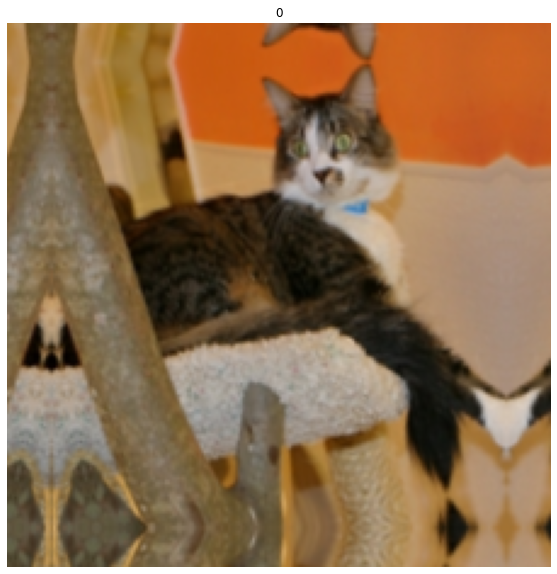

In [60]:
import numpy as np
import random

# visualize what the first few image of the first batch looks like after various 
# random transformations
for image, label in train_ds.take(1):
  # Set figure size 
  plt.figure(figsize=(10,10))
  #ax = plt.subplot(3,3,i+1)
  augmented_image = data_augmentation(image,training=True)
  # Train_ds is already batched so just select first element from the batch
  # and plot it 
  i = random.choice(range(BATCH_SIZE))
  plt.imshow(augmented_image[i].numpy() / 255.)
  plt.title(int(label[i]))
  plt.axis('off')

In [64]:
from tensorflow.keras.layers.experimental import preprocessing

# Model_2, Using data augmentation layer in the model
# Build model using Functional API 
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = preprocessing.Rescaling(1/255.)(inputs) # Normalizing pixel data 
x = data_augmentation(x) # augmenting images during training
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="Model_2_Rescaled_Augmented")

In [65]:
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [67]:
history_2 = model_2.fit(train_ds, epochs=10, # train for 10 epochs
                        steps_per_epoch=len(train_ds),
                        validation_data=validation_ds,
                        validation_steps=int(0.25*len(validation_ds)), # validated on only 25% of validation_ds
                        callbacks=[model_checkpoint(model_name=model_2.name)])

Epoch 1/10
581/582 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.7170

582/582 [==============================] - 52s 90ms/step - loss: 0.5483 - accuracy: 0.7168 - val_loss: 0.4865 - val_accuracy: 0.7743
Epoch 2/10
581/582 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.7307

582/582 [==============================] - 44s 75ms/step - loss: 0.5309 - accuracy: 0.7307 - val_loss: 0.4870 - val_accuracy: 0.7795
Epoch 3/10
581/582 [============================>.] - ETA: 0s - loss: 0.5184 - accuracy: 0.7420

582/582 [==============================] - 43s 74ms/step - loss: 0.5185 - accuracy: 0.7420 - val_loss: 0.4935 - val_accuracy: 0.7899
Epoch 4/10
581/582 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.7511

582/582 [==============================] - 48s 83ms/step - loss: 0.5065 - accuracy: 0.7511 - val_loss: 0.4788 - val_accuracy: 0.7934
Epoch 5/10
582/582 [==============================] - 42s 73ms/step - loss: 0.5028 - accuracy: 0.7536 - val_loss: 0.4798 - val_accuracy: 0.7778
Epoch 6/10
582/582 [==============================] - 42s 72ms/step - loss: 0.4942 - accuracy: 0.7617 - val_loss: 0.4732 - val_accuracy: 0.7882
Epoch 7/10
582/582 [==============================] - 41s 71ms/step - loss: 0.4904 - accuracy: 0.7633 - val_loss: 0.4610 - val_accuracy: 0.7899
Epoch 8/10
582/582 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.7735

582/582 [==============================] - 43s 74ms/step - loss: 0.4789 - accuracy: 0.7735 - val_loss: 0.4445 - val_accuracy: 0.8125
Epoch 9/10
581/582 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.7772

582/582 [==============================] - 44s 76ms/step - loss: 0.4733 - accuracy: 0.7773 - val_loss: 0.4244 - val_accuracy: 0.8160
Epoch 10/10
582/582 [==============================] - 43s 73ms/step - loss: 0.4666 - accuracy: 0.7809 - val_loss: 0.4532 - val_accuracy: 0.8003


In [68]:
model_2_results = model_2.evaluate(test_ds)

73/73 [==============================] - 3s 43ms/step - loss: 0.4615 - accuracy: 0.7837


In [69]:
# Load in best model 
model_2 = tf.keras.models.load_model("/content/model_experiments/Model_2_Rescaled_Augmented")

In [70]:
# Do we see an improvement
model_2_results = model_2.evaluate(test_ds)
model_2_results

73/73 [==============================] - 3s 42ms/step - loss: 0.4329 - accuracy: 0.7885


[0.4328746795654297, 0.7884780764579773]

In [72]:
model_1_results

[0.4870499074459076, 0.7708512544631958]

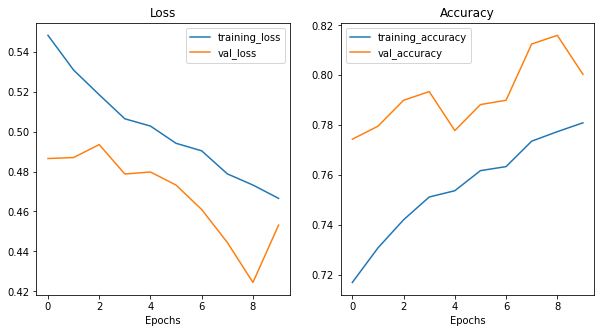

In [71]:
plot_loss_curves(history_2)

Very slight increase from model_1 with the data augmentation and training for 10 epochs instead of 5. The data augmentation did help with the overfitting. Our traning curves are more inline with what we like to see.

Let's add some callbacks
- ReduceLROnPlateau
- EarlyStopping

### Model w/ Additional Callbacks (Model 3)

In [73]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_delta=0.05, min_lr=0.000001, verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, min_delta=0.05,
                               restore_best_weights=True)

In [74]:
from tensorflow.keras.layers.experimental import preprocessing

# Model_3, Adding two callbacks
# Build model using Functional API 
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = preprocessing.Rescaling(1/255.)(inputs) # Normalizing pixel data 
x = data_augmentation(x) # augmenting images during training
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="Model_3_Rescaled_augmented_callbacks")

In [75]:
model_3.name

'Model_3_Rescaled_augmented_callbacks'

In [76]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [77]:
history_3 = model_3.fit(train_ds, 
                        epochs=30,
                        steps_per_epoch=len(train_ds),
                        validation_data=validation_ds,
                        validation_steps=int(0.25*len(validation_ds)),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_name=model_3.name)])

Epoch 1/30
581/582 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6092

582/582 [==============================] - 44s 74ms/step - loss: 0.6517 - accuracy: 0.6090 - val_loss: 0.6217 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 2/30
582/582 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.6730

582/582 [==============================] - 43s 74ms/step - loss: 0.6017 - accuracy: 0.6730 - val_loss: 0.5304 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 3/30
582/582 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.7080

582/582 [==============================] - 44s 76ms/step - loss: 0.5674 - accuracy: 0.7080 - val_loss: 0.5201 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 4/30
581/582 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.7239

582/582 [==============================] - 43s 74ms/step - loss: 0.5453 - accuracy: 0.7240 - val_loss: 0.5136 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 5/30
582/582 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7306
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


582/582 [==============================] - 45s 77ms/step - loss: 0.5333 - accuracy: 0.7306 - val_loss: 0.5128 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 6/30
582/582 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7472

582/582 [==============================] - 44s 76ms/step - loss: 0.5064 - accuracy: 0.7472 - val_loss: 0.4905 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 7/30
581/582 [============================>.] - ETA: 0s - loss: 0.4989 - accuracy: 0.7562

582/582 [==============================] - 45s 77ms/step - loss: 0.4988 - accuracy: 0.7563 - val_loss: 0.4864 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 8/30
582/582 [==============================] - 41s 70ms/step - loss: 0.4965 - accuracy: 0.7584 - val_loss: 0.4835 - val_accuracy: 0.7865 - lr: 1.0000e-04
Epoch 9/30
581/582 [============================>.] - ETA: 0s - loss: 0.4927 - accuracy: 0.7618
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
582/582 [==============================] - 41s 70ms/step - loss: 0.4929 - accuracy: 0.7616 - val_loss: 0.4829 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 10/30
582/582 [==============================] - 42s 71ms/step - loss: 0.4870 - accuracy: 0.7654 - val_loss: 0.4866 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 11/30
582/582 [==============================] - 41s 71ms/step - loss: 0.4894 - accuracy: 0.7623 - val_loss: 0.4867 - val_accuracy: 0.7795 - lr: 1.0000e-05


In [78]:
model_3_results = model_3.evaluate(test_ds)
model_3_results

73/73 [==============================] - 3s 42ms/step - loss: 0.4723 - accuracy: 0.7709


[0.4722824692726135, 0.7708512544631958]

In [79]:
# Load in the best weights stored using our ModelCheckpoint callback
model_3 = tf.keras.models.load_model("/content/model_experiments/Model_3_Rescaled_augmented_callbacks")

In [80]:
model_3_results = model_3.evaluate(test_ds)
model_3_results

73/73 [==============================] - 3s 45ms/step - loss: 0.4673 - accuracy: 0.7794


[0.46734827756881714, 0.7794497013092041]

In [81]:
model_2_results

[0.4328746795654297, 0.7884780764579773]

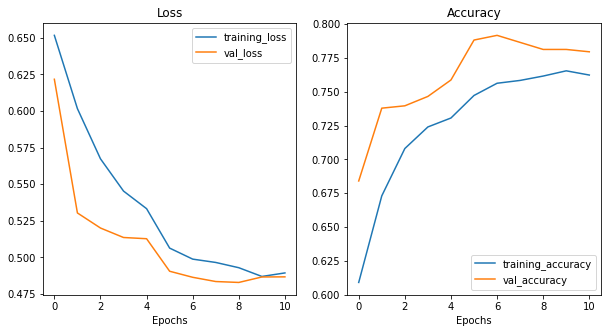

In [82]:
plot_loss_curves(history_3)

Model_3 did not provide any imporvement over model_2 and took longer to train

## Transfer Learning
- EfficientNetBX

So far, we have kept our architecture the same (TinyVGG) throughout all of our experiments. We have changed our models through the following methods so far:
- Normalizing pixel data (pixel data between 0 & 1)
  - Increased our `test_ds` accuracy by ~15%
- Added a data augmentation layer and trained for 5 more epochs
- Added `ReduceLROnPlateau`, `EarlyStopping`, and callbacks
  - Did not increase our test accuracy

Now, we will bring in the EfficientNetBX model and see how it performs on our data of Cats and Dogs

### Feature Extraction Model (Model_4)

In [83]:
# We will use EfficientNetB4
INPUT_SHAPE = (224,224,3) # Use same input shape as previous models

# Create base model 
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # Just building feature extraction model. Must make base_model untrainable

# Build the functional model (model_4)
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
# EfficientNetBX models have rescaling built into them
x = base_model(inputs, training=False) # Do not train all the layers 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', dtype=tf.float32, name='sigmoid_float32')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_EfficientNetB4')

# Compile the model 
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

71686520/71686520 [==============================] - 1s 0us/step


In [88]:
model_4.name

'model_4_EfficientNetB4'

In [84]:
model_4.summary()

Model: "model_4_EfficientNetB4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_7 (Dense)             (None, 1)                 1793      
                                                                 
 sigmoid_float32 (Activation  (None, 1)                0         
 )                                                               
                                                                 
Total params: 17,675,616
Trainable params: 1

In [86]:
# Check layer trainability of the model
for layer in model_4.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb4 False
global_average_pooling2d True
dense_7 True
sigmoid_float32 True


In [ ]:
# Examine all the layers of the base_model (EfficientNetB4)
for layer in base_model.layers:
  print(layer.name)

In [89]:
# Fit the model (just train for 3 epochs)
history_4_feature_extraction = model_4.fit(train_ds,
                                           epochs=3,
                                           steps_per_epoch=len(train_ds),
                                           validation_data=validation_ds,
                                           validation_steps=int(0.25*len(validation_ds)),
                                           callbacks=[model_checkpoint(model_name=model_4.name)])

Epoch 1/3
582/582 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9880

582/582 [==============================] - 182s 294ms/step - loss: 0.0640 - accuracy: 0.9880 - val_loss: 0.0292 - val_accuracy: 0.9948
Epoch 2/3
582/582 [==============================] - 87s 149ms/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 0.0256 - val_accuracy: 0.9931
Epoch 3/3
582/582 [==============================] - 87s 150ms/step - loss: 0.0196 - accuracy: 0.9943 - val_loss: 0.0254 - val_accuracy: 0.9913


In [90]:
model_4_results = model_4.evaluate(test_ds)

73/73 [==============================] - 11s 154ms/step - loss: 0.0208 - accuracy: 0.9940


Obviously, our transfer learning model utilizing EfficientNetB4 wins by a landslide. Given this is simple binary image classification. We really could have just trained for one epoch. Based off of our training curves, just training for one epoch looks superior to 3 anyways 

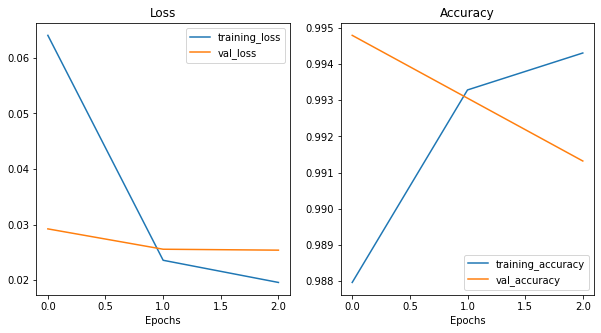

In [91]:
plot_loss_curves(history_4_feature_extraction)

Next step, if we were still unhappy with the performance of our model, could be fine-tuning the base_model (i.e. making the top X layers trainable) but there is no need given the almost perfect accuracy acheived already using just the EfficientNetB4 Feature Extraction Model 

## Making Predictions with our feature extraction model (model_4)

In [92]:
class_names = ["Cat", "Dog"]

In [93]:
# Make predictions
# Will output probabilities between 0 & 1
model_4_pred_probs = model_4.predict(test_ds)
model_4_pred_probs[:10]

73/73 [==============================] - 13s 138ms/step


array([[4.9653305e-03],
       [9.9830651e-01],
       [9.9579018e-01],
       [1.1140752e-03],
       [1.4576264e-06],
       [1.7530723e-05],
       [9.9997211e-01],
       [5.3033967e-02],
       [2.8062670e-04],
       [3.2234635e-05]], dtype=float32)

In [94]:
model_4_pred_probs.shape

(2326, 1)

In [95]:
model_4_pred_probs = tf.squeeze(model_4_pred_probs)
model_4_pred_probs.shape

TensorShape([2326])

In [103]:
tf.round(model_4_pred_probs[0]).numpy()

0.0

In [107]:
model_4_pred_probs[0].shape

TensorShape([])

In [113]:
class_names[int(tf.round(model_4_pred_probs[0]).numpy())]

'Cat'

In [115]:
# Pretty print 
print(f"Shape of the prediction probability array: {model_4_pred_probs.shape}")
print(f"Predicted class for sample 0: {int(tf.round(model_4_pred_probs[0]).numpy())}")
print(f"Name of the predicted class for sample 0: {class_names[int(tf.round(model_4_pred_probs[0]).numpy())]}")

Shape of the prediction probability array: (2326,)
Predicted class for sample 0: 0
Name of the predicted class for sample 0: Cat


In [116]:
# Turn probabilities into actual binary prediction
model_4_preds = tf.round(model_4_pred_probs)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [122]:
test_ds.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Get labels from test_ds (batched, prefetched dataset)
true_labels = []
for _, label in list(test_ds.unbatch().as_numpy_iterator()):
  true_labels.append(label)
true_labels

In [127]:
# Ensure our true_label list is correct
type(true_labels), len(true_labels), max(true_labels), min(true_labels)

(list, 2326, 1, 0)

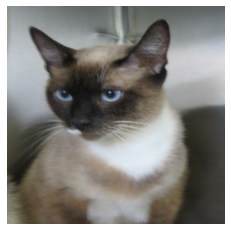

In [182]:
# Plot an image from our test_ds
test_images = np.empty([2326, 224, 224 , 3])
for image, _ in test_ds.unbatch().as_numpy_iterator():
  plt.imshow(image / 255.)
  plt.axis(False)
  break

## Plotting our Predictions using Feature Extraction Model (model_4)

In [206]:
import matplotlib.pyplot as plt

def plot_preds(dataset, class_names):
  """
  Function that plots a model's predicted image and associated image and whether
  or not the prediction is correct (green = correct, red = incorrect)

  Args
  -----

  true_labels : (list or array-like) the true labels of the dataset predicting on

  dataset : tf.data.Dataset (most likely test or validation dataset)

  class_names : (list) list of class names from the dataset

  Returns
  -------
  A plot of the image predicted on and the predicted label

  """
  # Get random image
  # Unefficient way to get a target_image
  target_image = dataset.unbatch().shuffle(buffer_size=2326).take(1).get_single_element()[0].numpy()

  pred_prob = model_4.predict(tf.expand_dims(target_image, 0), verbose=0)
  pred_label = int(tf.round(pred_prob).numpy())

  plt.figure(figsize=(10,7))
  plt.imshow(target_image / 255.)
  plt.title(f"Predicted class: {class_names[pred_label]}")
  plt.axis(False);


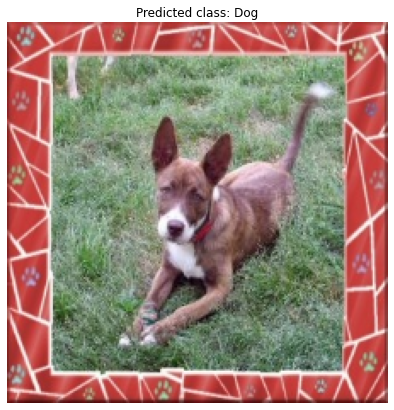

In [207]:
plot_preds(dataset=test_ds, class_names=class_names)

### Loading and Saving our Feature Extraction model 

In [129]:
# Saving our feature extraction model 
model_4.save("/content/drive/MyDrive/Colab Notebooks/Cats_v_dogs_CNN")

In [209]:
# Load our feature extraction model 
model_4 = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/Cats_v_dogs_CNN")

In [211]:
# Ensure model was loaded correctly
model_4.evaluate(test_ds)

73/73 [==============================] - 15s 152ms/step - loss: 0.0208 - accuracy: 0.9940


[0.020816000178456306, 0.9939810633659363]